In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import glob
import re
import openpyxl
import math
from matplotlib import pyplot as plt
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.optimize import minimize
import seaborn as sns
from scipy.stats import weibull_min

## 1. Out of money put and call price aggregate

In [2]:
futures = pd.read_csv("./data/futures.csv")
options = pd.read_csv("./data/options.csv")

In [3]:
futures.head()

,Timestamp,Product,RefDate,AssetDescription,Expiration,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE
0,2023-01-03 15:00:00,SOFR3,2027-12-15,SR3 2028-03-14,2028-03-14,96.685,259,96.695,245,96.6900,96.690139
1,2023-01-03 15:00:00,SOFR3,2024-03-20,SR3 2024-06-18,2024-06-18,95.880,1511,95.885,245,95.8825,95.884302
2,2023-01-03 15:00:00,SOFR3,2026-09-16,SR3 2026-12-15,2026-12-15,96.810,1136,96.820,1153,96.8150,96.814963
3,2023-01-03 15:00:00,SOFR3,2025-06-18,SR3 2025-09-16,2025-09-16,96.835,1379,96.840,90,96.8375,96.839694
4,2023-01-03 15:00:00,SOFR3,2027-03-17,SR3 2027-06-15,2027-06-15,96.770,141,96.775,50,96.7725,96.773691


In [13]:
options.head()

,Timestamp,AssetDescription,BaseAssetName,Expiration,StrikePrice,AssetTypeName,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE
0,2023-01-03 15:00:00,SR3 2023-01-13 00:00:00 Calls 95.4375,SR3,2023-01-13,95.4375,Calls,0.0025,742,0.0075,1713,0.00500,0.004011
1,2023-01-03 15:00:00,SR3 2023-01-13 00:00:00 Puts 95.1875,SR3,2023-01-13,95.1875,Puts,0.1150,2198,0.1300,2369,0.12250,0.122219
2,2023-01-03 15:00:00,SR3 2023-01-13 00:00:00 Calls 95.1875,SR3,2023-01-13,95.1875,Calls,0.0150,1578,0.0225,1974,0.01875,0.018332
3,2023-01-03 15:00:00,SR3 2023-01-13 00:00:00 Puts 95.9375,SR3,2023-01-13,95.9375,Puts,0.8450,282,0.8650,282,0.85500,0.855000
4,2023-01-03 15:00:00,SR3 2023-01-13 00:00:00 Puts 95.0625,SR3,2023-01-13,95.0625,Puts,0.0425,5435,0.0550,10681,0.04875,0.046716


In [4]:
options = options[options['BaseAssetName'] == "SR3"].copy()
futures = futures[futures['Product'] == 'SOFR3'].copy()

In [30]:
options['Timestamp'] = pd.to_datetime(options['Timestamp'])
options['Expiration'] = pd.to_datetime(options['Expiration'])
options['year'] = [date.year for date in options['Expiration']]
options['month'] = [date.month for date in options['Expiration']]
futures['Timestamp'] = pd.to_datetime(futures['Timestamp'])
futures['Expiration'] = pd.to_datetime(futures['Expiration'])
futures['year'] = [date.year for date in futures['Expiration']]
futures['month'] = [date.month for date in futures['Expiration']]

In [19]:
futures.sort_values(['Expiration', 'Timestamp'])

,Timestamp,Product,RefDate,AssetDescription,Expiration,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE
769,2023-02-01 15:00:00,SOFR3,2022-11-16,SR3 2023-02-14,2023-02-14,95.7925,150,95.7975,50,95.79500,95.796250
1032,2023-02-10 15:00:00,SOFR3,2022-11-16,SR3 2023-02-14,2023-02-14,95.7975,1350,95.8000,2077,95.79875,95.798485
6,2023-01-03 15:00:00,SOFR3,2022-12-21,SR3 2023-03-14,2023-03-14,95.4975,9453,95.5000,9,95.49875,95.499998
43,2023-01-04 15:00:00,SOFR3,2022-12-21,SR3 2023-03-14,2023-03-14,95.5000,3894,95.5025,8535,95.50125,95.500783
80,2023-01-05 15:00:00,SOFR3,2022-12-21,SR3 2023-03-14,2023-03-14,95.4900,4942,95.4925,8033,95.49125,95.490952
...,...,...,...,...,...,...,...,...,...,...,...
4564,2023-06-23 15:00:00,SOFR3,2028-03-15,SR3 2028-06-20,2028-06-20,96.7150,1423,96.7200,115,96.71750,96.719626
4602,2023-06-26 15:00:00,SOFR3,2028-03-15,SR3 2028-06-20,2028-06-20,96.7550,60,96.7600,1946,96.75750,96.755150
4641,2023-06-27 15:00:00,SOFR3,2028-03-15,SR3 2028-06-20,2028-06-20,96.7300,606,96.7350,478,96.73250,96.732795
4678,2023-06-28 15:00:00,SOFR3,2028-03-15,SR3 2028-06-20,2028-06-20,96.7850,322,96.7900,381,96.78750,96.787290


In [5]:
len(options)

161099

In [85]:
futures_use = futures[['Timestamp', 'year', 'month', 'MICRO_PRICE', 'RefDate']].copy()

In [86]:
options_all = options.merge(futures_use, left_on=['Timestamp', 'year', 'month'], right_on=['Timestamp', 'year', 'month'], how='left')

In [87]:
options_all = options_all.dropna()
options_calls = options_all[(options_all['StrikePrice'] >= options_all['MICRO_PRICE_y']) & (options_all['AssetTypeName'] == 'Calls')].copy()
options_puts = options_all[(options_all['StrikePrice'] <= options_all['MICRO_PRICE_y']) & (options_all['AssetTypeName'] == 'Puts')].copy()

In [88]:
options_all = pd.concat([options_calls, options_puts])
options_all

,Timestamp,AssetDescription,BaseAssetName,Expiration,StrikePrice,AssetTypeName,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE_x,year,month,MICRO_PRICE_y,RefDate
63,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 97.3125,SR3,2023-03-10,97.3125,Calls,0.0025,13549,0.0075,26577,0.00500,0.004188,2023,3,95.499998,2022-12-21
64,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 97.0625,SR3,2023-03-10,97.0625,Calls,0.0025,13371,0.0100,41641,0.00625,0.004323,2023,3,95.499998,2022-12-21
65,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 96.5625,SR3,2023-03-10,96.5625,Calls,0.0050,4806,0.0125,26528,0.00875,0.006150,2023,3,95.499998,2022-12-21
66,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 96.4375,SR3,2023-03-10,96.4375,Calls,0.0050,4863,0.0125,25790,0.00875,0.006190,2023,3,95.499998,2022-12-21
67,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 97.1875,SR3,2023-03-10,97.1875,Calls,0.0025,17853,0.0075,21820,0.00500,0.004750,2023,3,95.499998,2022-12-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161094,2023-06-29 15:00:00,SR3 2023-10-13 00:00:00 Puts 93.625,SR3,2023-10-13,93.6250,Puts,0.0075,3241,0.0150,6306,0.01125,0.010046,2023,10,94.687788,2023-07-19
161095,2023-06-29 15:00:00,SR3 2023-10-13 00:00:00 Puts 93.4375,SR3,2023-10-13,93.4375,Puts,0.0050,3995,0.0175,1367,0.01125,0.014313,2023,10,94.687788,2023-07-19
161096,2023-06-29 15:00:00,SR3 2023-10-13 00:00:00 Puts 93.375,SR3,2023-10-13,93.3750,Puts,0.0050,406,0.0175,14563,0.01125,0.005339,2023,10,94.687788,2023-07-19
161097,2023-06-29 15:00:00,SR3 2023-10-13 00:00:00 Puts 93.3125,SR3,2023-10-13,93.3125,Puts,0.0050,224,0.0150,653,0.01000,0.007554,2023,10,94.687788,2023-07-19


In [89]:
options_all = options_all.sort_values(['Expiration', 'Timestamp'])
options_all

,Timestamp,AssetDescription,BaseAssetName,Expiration,StrikePrice,AssetTypeName,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE_x,year,month,MICRO_PRICE_y,RefDate
20843,2023-02-01 15:00:00,SR3 2023-02-10 00:00:00 Puts 95.125,SR3,2023-02-10,95.1250,Puts,0.0025,2223,0.0075,642,0.00500,0.006380,2023,2,95.796250,2022-11-16
20846,2023-02-01 15:00:00,SR3 2023-02-10 00:00:00 Puts 95.4375,SR3,2023-02-10,95.4375,Puts,0.2550,1,0.2700,1,0.26250,0.262500,2023,2,95.796250,2022-11-16
20849,2023-02-01 15:00:00,SR3 2023-02-10 00:00:00 Puts 95.5625,SR3,2023-02-10,95.5625,Puts,0.3800,1,0.3950,1,0.38750,0.387500,2023,2,95.796250,2022-11-16
20851,2023-02-01 15:00:00,SR3 2023-02-10 00:00:00 Puts 95.6875,SR3,2023-02-10,95.6875,Puts,0.5050,1,0.5200,1,0.51250,0.512500,2023,2,95.796250,2022-11-16
20856,2023-02-01 15:00:00,SR3 2023-02-10 00:00:00 Puts 95.1875,SR3,2023-02-10,95.1875,Puts,0.0225,239,0.0350,1367,0.02875,0.024360,2023,2,95.796250,2022-11-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160743,2023-06-29 15:00:00,SR3 2025-12-12 00:00:00 Calls 96.5,SR3,2025-12-12,96.5000,Calls,0.8200,54,0.8900,54,0.85500,0.855000,2025,12,96.493103,2025-09-17
160740,2023-06-29 15:00:00,SR3 2025-12-12 00:00:00 Puts 95.0,SR3,2025-12-12,95.0000,Puts,0.3150,147,0.3500,40,0.33250,0.342513,2025,12,96.493103,2025-09-17
160746,2023-06-29 15:00:00,SR3 2025-12-12 00:00:00 Puts 95.875,SR3,2025-12-12,95.8750,Puts,0.5300,127,0.5900,127,0.56000,0.560000,2025,12,96.493103,2025-09-17
160748,2023-06-29 15:00:00,SR3 2025-12-12 00:00:00 Puts 95.625,SR3,2025-12-12,95.6250,Puts,0.4600,133,0.5100,133,0.48500,0.485000,2025,12,96.493103,2025-09-17


In [64]:
options_all.Expiration.unique()

array(['2023-03-10T00:00:00.000000000', '2023-04-14T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-06-16T00:00:00.000000000',
       '2023-12-15T00:00:00.000000000', '2024-03-15T00:00:00.000000000',
       '2024-06-14T00:00:00.000000000', '2024-09-13T00:00:00.000000000',
       '2024-12-13T00:00:00.000000000', '2025-03-14T00:00:00.000000000',
       '2025-06-13T00:00:00.000000000', '2023-09-15T00:00:00.000000000',
       '2025-12-12T00:00:00.000000000', '2023-07-14T00:00:00.000000000',
       '2025-09-12T00:00:00.000000000', '2023-08-11T00:00:00.000000000',
       '2023-10-13T00:00:00.000000000', '2023-11-10T00:00:00.000000000',
       '2023-02-10T00:00:00.000000000'], dtype='datetime64[ns]')

### Contract Expiration: 2023-04-14

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (T

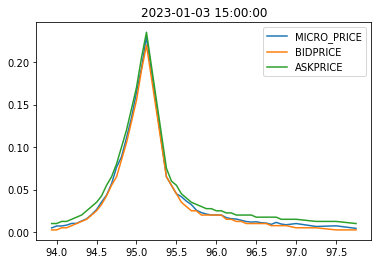

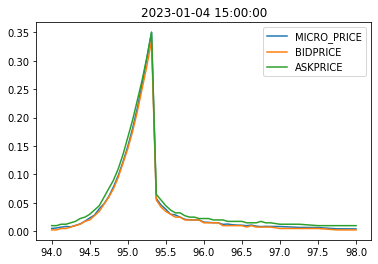

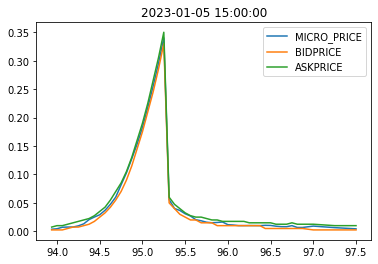

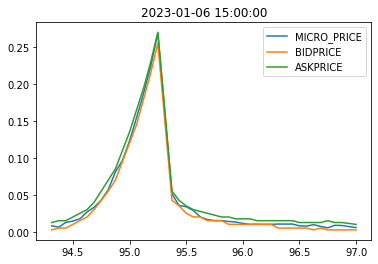

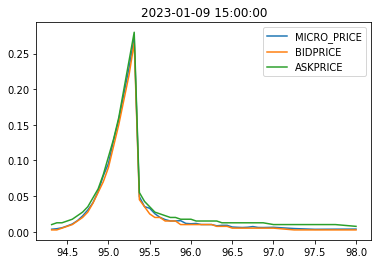

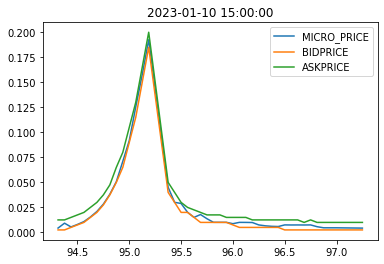

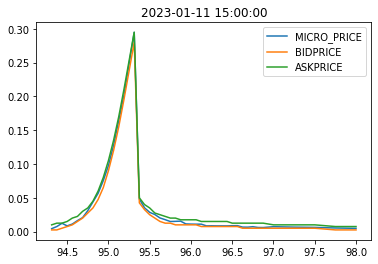

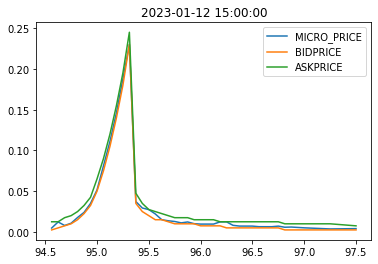

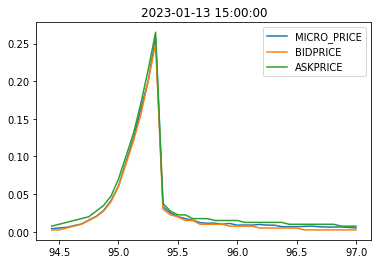

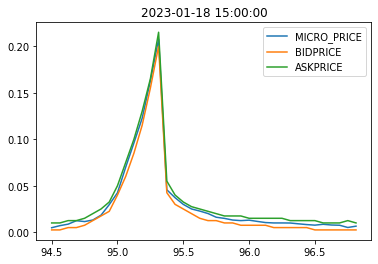

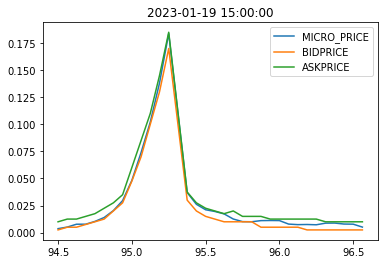

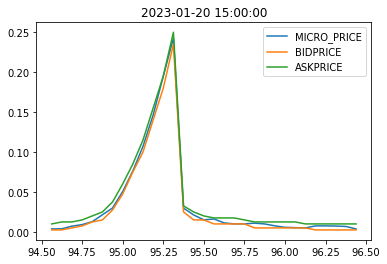

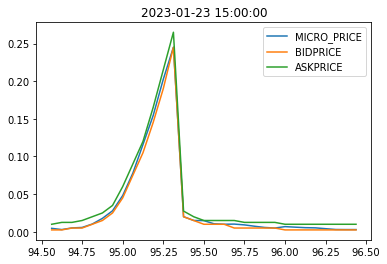

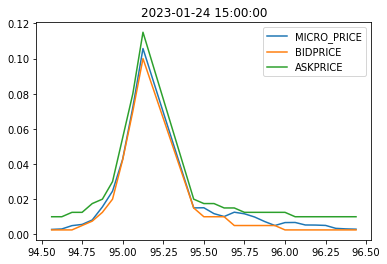

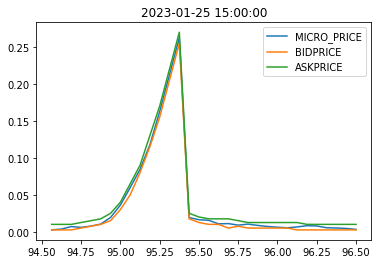

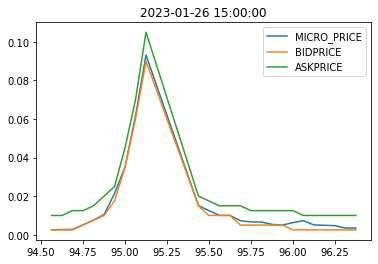

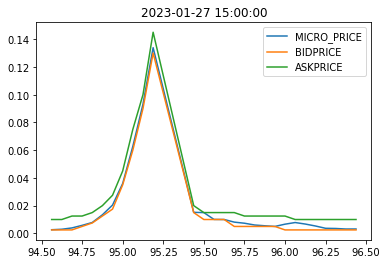

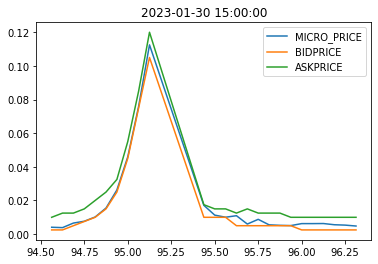

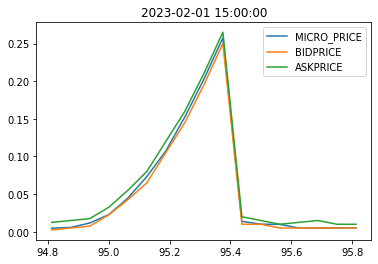

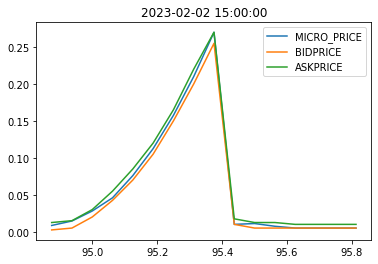

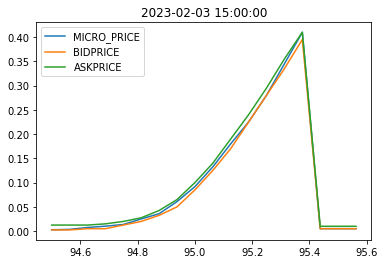

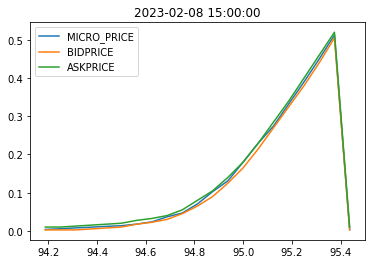

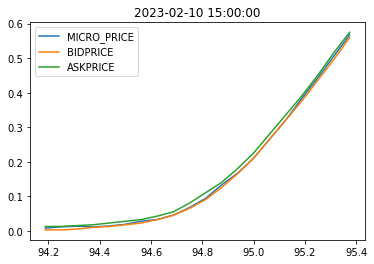

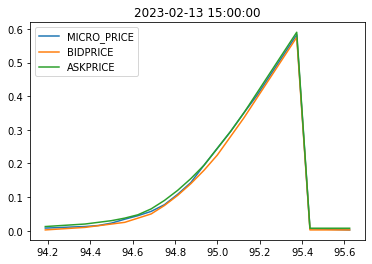

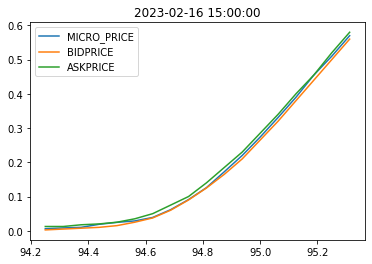

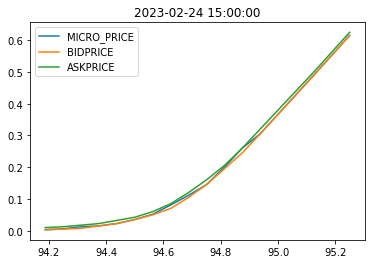

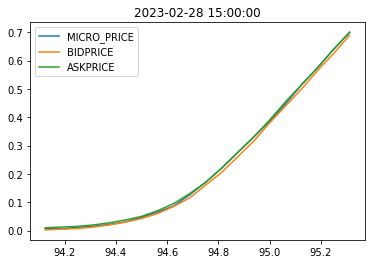

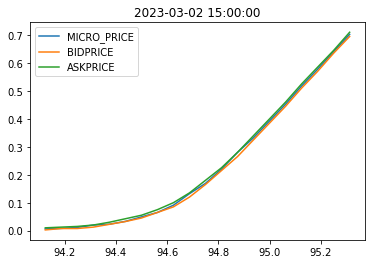

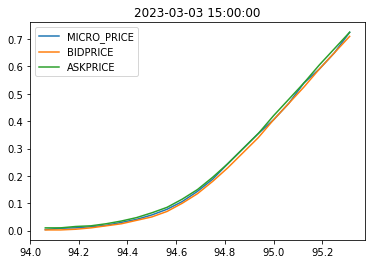

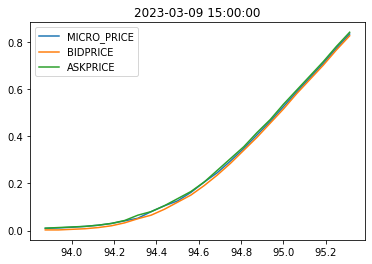

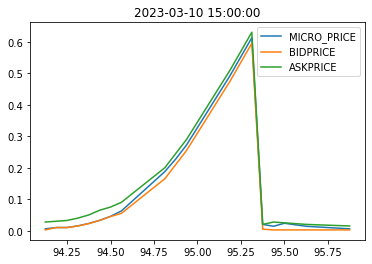

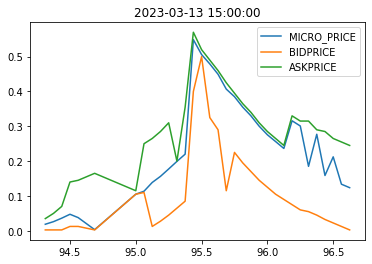

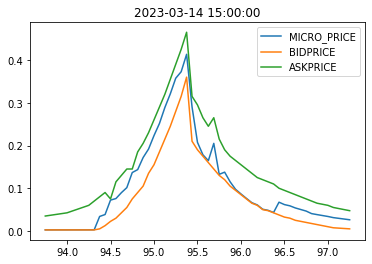

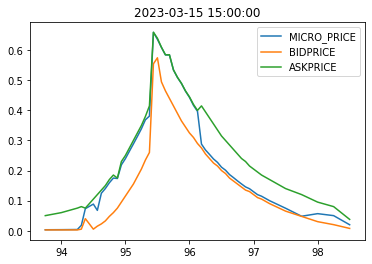

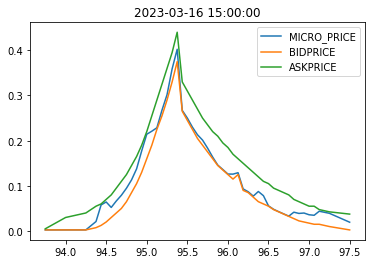

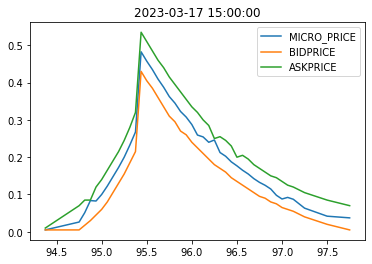

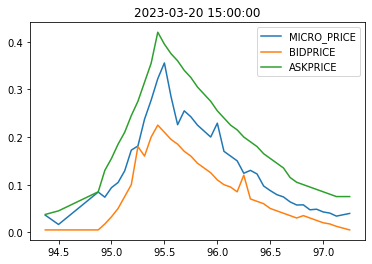

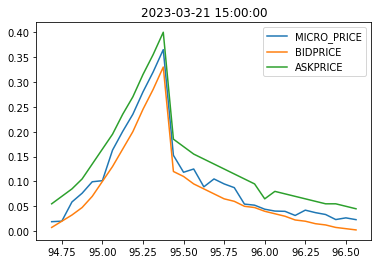

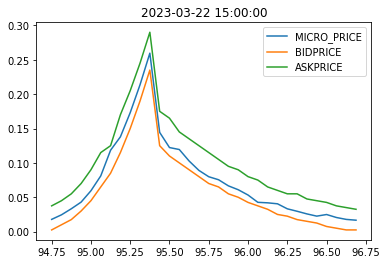

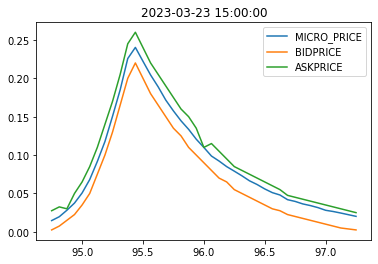

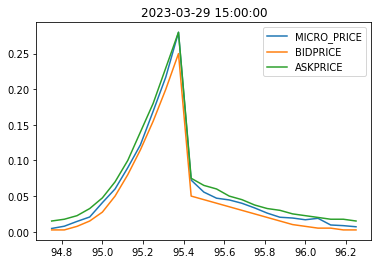

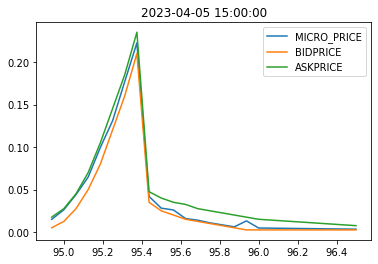

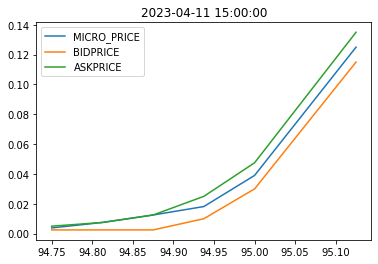

In [90]:
test = options_all[options_all['Expiration'] == '2023-04-14'].sort_values('StrikePrice')

grouped = test.groupby('Timestamp')

for t, g in grouped:
    plt.figure() # dpi=300, figsize=(10, 6)
    plt.plot(g.StrikePrice, g.MICRO_PRICE_x)
    plt.plot(g.StrikePrice, g.BIDPRICE0)
    plt.plot(g.StrikePrice, g.ASKPRICE0)
    plt.title(t)
    plt.legend(['MICRO_PRICE', 'BIDPRICE', 'ASKPRICE'])

In [91]:
options_all.to_csv('./data/clean/options_all.csv')

## Fed Rate and sofr rate

In [80]:
FEDRates = {}
path = './data/rate_curve'
csv_files = glob.glob(os.path.join(path, "FEDDecisionDist_*.csv"))

# keys format: yyyymmdd
for f in csv_files:
    date = re.findall(r'\d+', f)[0][:-6]
    FEDRates[date] = pd.read_csv(f)
    FEDRates[date] = FEDRates[date].rename(columns={'Unnamed: 0': 'Date'})
    FEDRates[date]['Date'] = pd.to_datetime(FEDRates[date]['Date'])

In [81]:
FEDRates.keys()

dict_keys(['20230104', '20230512', '20230110', '20230131', '20230307', '20230313', '20230125', '20230615', '20230109', '20230203', '20230217', '20230601', '20230620', '20230222', '20230301', '20230315', '20230123', '20230208', '20230428', '20230320', '20230626', '20230410', '20230224', '20230404', '20230519', '20230613', '20230425', '20230607', '20230327', '20230111', '20230105', '20230124', '20230526', '20230130', '20230306', '20230216', '20230614', '20230202', '20230403', '20230223', '20230621', '20230417', '20230228', '20230314', '20230321', '20230117', '20230501', '20230515', '20230209', '20230103', '20230405', '20230627', '20230411', '20230606', '20230210', '20230518', '20230612', '20230424', '20230525', '20230419', '20230127', '20230531', '20230106', '20230330', '20230510', '20230504', '20230324', '20230112', '20230622', '20230308', '20230414', '20230421', '20230201', '20230509', '20230215', '20230329', '20230516', '20230608', '20230322', '20230502', '20230303', '20230629', '2023

In [115]:
rates

,Date,-0.0125,-0.01,-0.0075,-0.005,-0.0025,0.0,0.0025,0.005,0.0075,0.01,0.0125
0,2023-02-01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.641895,0.358105,0.000000,0.000000,0.000000
1,2023-03-22,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.142646,0.578829,0.278524,0.000000,0.000000
2,2023-05-03,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.088049,0.411883,0.393464,0.106604,0.000000
3,2023-06-14,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.081800,0.388899,0.394772,0.126963,0.007566
4,2023-07-26,0.0,0.0,0.000000,0.000000,0.000000,0.012422,0.128437,0.389791,0.354102,0.108831,0.006417
5,2023-09-20,0.0,0.0,0.000000,0.000000,0.003540,0.045484,0.202917,0.379620,0.284205,0.079646,0.004588
6,2023-11-01,0.0,0.0,0.000000,0.001821,0.025111,0.126448,0.293791,0.330551,0.179005,0.041046,0.002229
7,2023-12-13,0.0,0.0,0.001032,0.015016,0.082527,0.221262,0.314619,0.244687,0.100839,0.019052,0.000966


In [107]:
rates = FEDRates['20230104']
MeetingDates = rates.Date

In [92]:
options04 = test.copy()
options04 = options04.sort_values('Timestamp')
options04

,Timestamp,AssetDescription,BaseAssetName,Expiration,StrikePrice,AssetTypeName,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE_x,year,month,MICRO_PRICE_y,RefDate
190,2023-01-03 15:00:00,SR3 2023-04-14 00:00:00 Calls 96.375,SR3,2023-04-14,96.3750,Calls,0.0100,1116,0.0200,3620,0.01500,0.012356,2023,4,95.321935,2023-01-18
184,2023-01-03 15:00:00,SR3 2023-04-14 00:00:00 Calls 96.75,SR3,2023-04-14,96.7500,Calls,0.0075,523,0.0175,829,0.01250,0.011368,2023,4,95.321935,2023-01-18
129,2023-01-03 15:00:00,SR3 2023-04-14 00:00:00 Puts 94.625,SR3,2023-04-14,94.6250,Puts,0.0425,587,0.0550,7697,0.04875,0.043386,2023,4,95.321935,2023-01-18
136,2023-01-03 15:00:00,SR3 2023-04-14 00:00:00 Calls 95.625,SR3,2023-04-14,95.6250,Calls,0.0300,3456,0.0400,1980,0.03500,0.036358,2023,4,95.321935,2023-01-18
168,2023-01-03 15:00:00,SR3 2023-04-14 00:00:00 Calls 95.9375,SR3,2023-04-14,95.9375,Calls,0.0200,183,0.0275,13981,0.02375,0.020097,2023,4,95.321935,2023-01-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85714,2023-04-11 15:00:00,SR3 2023-04-14 00:00:00 Puts 94.8125,SR3,2023-04-14,94.8125,Puts,0.0025,582,0.0075,1,0.00500,0.007491,2023,4,95.385037,2023-01-18
85725,2023-04-11 15:00:00,SR3 2023-04-14 00:00:00 Puts 95.125,SR3,2023-04-14,95.1250,Puts,0.1150,1,0.1350,1,0.12500,0.125000,2023,4,95.385037,2023-01-18
85720,2023-04-11 15:00:00,SR3 2023-04-14 00:00:00 Puts 94.75,SR3,2023-04-14,94.7500,Puts,0.0025,1588,0.0050,1405,0.00375,0.003826,2023,4,95.385037,2023-01-18
85719,2023-04-11 15:00:00,SR3 2023-04-14 00:00:00 Puts 94.9375,SR3,2023-04-14,94.9375,Puts,0.0100,14461,0.0250,12087,0.01750,0.018171,2023,4,95.385037,2023-01-18


In [94]:
begin_dates = options04.Timestamp.unique()
len(begin_dates)

43

In [102]:
begin_dates

array(['2023-01-03T15:00:00.000000000', '2023-01-04T15:00:00.000000000',
       '2023-01-05T15:00:00.000000000', '2023-01-06T15:00:00.000000000',
       '2023-01-09T15:00:00.000000000', '2023-01-10T15:00:00.000000000',
       '2023-01-11T15:00:00.000000000', '2023-01-12T15:00:00.000000000',
       '2023-01-13T15:00:00.000000000', '2023-01-18T15:00:00.000000000',
       '2023-01-19T15:00:00.000000000', '2023-01-20T15:00:00.000000000',
       '2023-01-23T15:00:00.000000000', '2023-01-24T15:00:00.000000000',
       '2023-01-25T15:00:00.000000000', '2023-01-26T15:00:00.000000000',
       '2023-01-27T15:00:00.000000000', '2023-01-30T15:00:00.000000000',
       '2023-02-01T15:00:00.000000000', '2023-02-02T15:00:00.000000000',
       '2023-02-03T15:00:00.000000000', '2023-02-08T15:00:00.000000000',
       '2023-02-10T15:00:00.000000000', '2023-02-13T15:00:00.000000000',
       '2023-02-16T15:00:00.000000000', '2023-02-24T15:00:00.000000000',
       '2023-02-28T15:00:00.000000000', '2023-03-02

In [112]:
exp_date = options04.Expiration.iloc[0]
obs_date = begin_dates[0]
date_ls = MeetingDates[(MeetingDates < exp_date) & (MeetingDates > obs_date)]
[(date_ls[i+1] - date_ls[i]).days for i in range(len(date_ls)-1)]

[49]

In [117]:
rates[rates['Date'] == '2023-02-01']

,Date,-0.0125,-0.01,-0.0075,-0.005,-0.0025,0.0,0.0025,0.005,0.0075,0.01,0.0125
0,2023-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.641895,0.358105,0.0,0.0,0.0


In [146]:
class Option():
    def __init__(self, name, expiration, type, K) -> None:
        # attri_ls = descrip_str.split(' ')
        self.baseassetname = name  # attri_ls[0]
        if self.baseassetname == 'SR3':
            self.baseassetfullname = 'SOFR3'
            self.contract_days = 91
        else:
            self.baseassetfullname = 'SOFR1'
            self.contract_days = 30
        self.expiration = pd.to_datetime(expiration)  # attri_ls[1]
        self.type = type   # attri_ls[3]
        self.K = K   # attri_ls[4]
        

    def obs_data(self, obsdate, bidprice, askprice):
        self.obsdate = obsdate
        self.datestr = datetime.strftime(self.obsdate, "%Y%m%d")
        self.bidprice = bidprice
        self.askprice = askprice
        self.datetomature = (self.expiration - self.obsdate).days


    def get_future(self, futures_df):
        if self.baseassetname == "SR3":
            self.expir_month = math.ceil(self.expiration.month/3) * 3
            #############################
            #TODO: 

            #############################
        else:
            self.expir_month = self.expiration.month

        baseassetdata = futures_df[(futures_df['Product'] == self.baseassetfullname) & (futures['month'] == self.expir_month) & (futures['year'] == self.expiration.year)].copy()
        baseassetdata = baseassetdata[baseassetdata['Timestamp'] == self.obsdate]
        if len(baseassetdata) == 0:
            date = self.obsdate - timedelta(1)
            baseassetdata = futures_df[(futures_df['Product'] == self.baseassetfullname) & (futures['month'] == self.expir_month) & (futures['year'] == self.expiration.year)].copy()
        baseassetdata = baseassetdata.iloc[0]
        self.baseasset = Future(baseassetdata.Product, baseassetdata.RefDate, 
                                baseassetdata.Expiration)
        self.baseasset.obs_data(baseassetdata.Timestamp, baseassetdata.MID_PRICE)
        return self.baseasset

    def get_discountrate(self, ratedict, method='simple'):
        
        bucketrate = ratedict[self.datestr]
        self.datetomature = (self.expiration - self.obsdate).days
        
        idx = bucketrate[bucketrate['CumLength'] > self.datetomature].index[0]
        rates = bucketrate.iloc[:idx+1, ].copy()
        # ratesls = rates['DailyRate']
        # daysls = rates['BucketLength']
        if len(rates) > 1:
            rates.iloc[-1, 2] = self.datetomature - rates['CumLength'].iloc[-2]
        else:
            rates.iloc[-1, 2] = self.datetomature
        # print(rates)

        # SIMPLE RATE
        if method == 'simple':
            rate = (rates['DailyRate'] * rates['BucketLength']).sum()/self.datetomature
        # COMPOUNDED RATE
        elif method == 'compounded':
            rate = 1
            if len(rates) == 1:
                rate = pow((1+rates['DailyRate'][0])**rates['BucketLength'][0], 1/self.datetomature) - 1
            else:
                for i in range(len(rates)):
                    rate *= (1+rates['DailyRate'][i])**rates['BucketLength'][i]
                rate = pow(rate, 1/self.datetomature) - 1
        # print(self.datetomature)
        return rate
    
    
    def cal_effectiverate(self, index):
        # realized rates: mean value
        self.realizedrate = index[(index['Effective Date'] <= self.obsdate) 
      & (index['Effective Date'] >= self.baseasset.begin)]['SOFR Index'].mean()
        self.todayrate = index[index['Effective Date'] <= self.obsdate].iloc[-1, ]['SOFR Index']
        
        self.realizedrate = (self.realizedrate - 1) * 100
        self.todayrate = (self.todayrate - 1) * 100


        self.effectiverate = ((100-self.baseasset.price) * self.contract_days - self.baseasset.days * self.realizedrate)/(self.contract_days-self.baseasset.days)

        ##### assume future rate == today rate in all the contract days. 
        self.ft = (self.realizedrate * self.baseasset.days + self.todayrate * (self.contract_days - self.baseasset.days)) / self.contract_days
        return self.todayrate, self.realizedrate, self.effectiverate    # , self.effectiverate
    

    # def cal_FT(self, noFOMC=False):
    #     if noFOMC:
    #         self.ft = (self.realizedrate * self.baseasset.days + self.todayrate * (self.contract_days - self.baseasset.days)) / self.contract_days
        

    def get_ratedistribution(self, feddict, exp_date):
        
        self.fedrateexp = feddict[self.datestr].copy()

        # need to use future contract expiration date to define the interval
        self.fedrateexp = self.fedrateexp[(self.fedrateexp['Date'] <= exp_date) & (self.fedrateexp['Date'] >= self.obsdate)]
        # self.ft = (self.realizedrate * self.baseasset.days + self.todayrate * (self.contract_days - self.baseasset.days)) / self.contract_days
        
        if len(self.fedrateexp) > 0:
            situationnum = 0
            probs = [1]
            ratechanges = [0]
            today = self.obsdate
            exprate = []
            days_intr = []
            for idx, row in self.fedrateexp.iterrows():
                rateprob = row[(row != 0)]
                del rateprob['Date']
                # FOMCdict[row['Date']] = rateprob
                prob = rateprob.values  
                probs = [i * j for i in probs for j in prob]
                # print(probs)
                ratechange = rateprob.index.values
                
                days_intr.append((exp_date - row['Date']).days)  # today
                today = row['Date']
                
                ## calculating the date length
                ## adjust rate change values
                ratechanges = [i + days_intr[-1]/self.contract_days*float(j) for i in ratechanges for j in ratechange]
                # print(ratechanges)
                exprate.append(sum([i*j for i in probs for j in ratechanges]))

            days_intr.append((exp_date - today).days)
            self.ratechanges = ratechanges; self.probs = probs;
            return probs, ratechanges
        else:
            print('no meeting.')
            self.probs = [1]
            self.ratechanges = [0]
            return [1], [0]

In [147]:
exp_date

Timestamp('2023-04-14 00:00:00')

In [149]:
grouped = options04.groupby('AssetDescription')
assetnew = []
for name, asset in grouped:
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    probs_ls, ratechanges_ls = [], []
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        probs, ratechanges = myoption.get_ratedistribution(FEDRates, exp_date)
        probs_ls.append(probs)
        ratechanges_ls.append(ratechanges)
        # print(probs, ratechanges)
    asset['Probs'] = probs_ls
    asset['RateChanges'] = ratechanges_ls
    assetnew.append(asset)
options04_new = pd.concat(assetnew)
options04_new

no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no meeting.
no m

,Timestamp,AssetDescription,BaseAssetName,Expiration,StrikePrice,AssetTypeName,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE_x,year,month,MICRO_PRICE_y,RefDate,Probs,RateChanges
2672,2023-01-05 15:00:00,SR3 2023-04-14 00:00:00 Calls 95.3125,SR3,2023-04-14,95.3125,Calls,0.0500,1951,0.0600,1423,0.05500,0.055782,2023,4,95.307125,2023-01-18,"[0.04899471956008274, 0.28711818109019, 0.2069...","[0.0026098901098901097, 0.003241758241758242, ..."
188,2023-01-03 15:00:00,SR3 2023-04-14 00:00:00 Calls 95.375,SR3,2023-04-14,95.3750,Calls,0.0650,10,0.0750,2601,0.07000,0.065038,2023,4,95.321935,2023-01-18,"[0.09595610155049408, 0.3629307911059366, 0.17...","[0.0026098901098901097, 0.003241758241758242, ..."
1421,2023-01-04 15:00:00,SR3 2023-04-14 00:00:00 Calls 95.375,SR3,2023-04-14,95.3750,Calls,0.0550,501,0.0650,1386,0.06000,0.057655,2023,4,95.327888,2023-01-18,"[0.09156398821566109, 0.37154749988015395, 0.1...","[0.0026098901098901097, 0.003241758241758242, ..."
2728,2023-01-05 15:00:00,SR3 2023-04-14 00:00:00 Calls 95.375,SR3,2023-04-14,95.3750,Calls,0.0400,20,0.0475,1112,0.04375,0.040133,2023,4,95.307125,2023-01-18,"[0.04899471956008274, 0.28711818109019, 0.2069...","[0.0026098901098901097, 0.003241758241758242, ..."
3787,2023-01-06 15:00:00,SR3 2023-04-14 00:00:00 Calls 95.375,SR3,2023-04-14,95.3750,Calls,0.0425,3972,0.0550,1692,0.04875,0.051266,2023,4,95.335172,2023-01-18,"[0.09268866795008089, 0.4392213898201942, 0.16...","[0.0026098901098901097, 0.003241758241758242, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65250,2023-03-21 15:00:00,SR3 2023-04-14 00:00:00 Puts 95.375,SR3,2023-04-14,95.3750,Puts,0.3300,80,0.4000,80,0.36500,0.365000,2023,4,95.386667,2023-01-18,"[0.130848962915416, 0.869151037084584]","[0.0, 0.0006318681318681318]"
66841,2023-03-22 15:00:00,SR3 2023-04-14 00:00:00 Puts 95.375,SR3,2023-04-14,95.3750,Puts,0.2350,171,0.2900,212,0.26250,0.259556,2023,4,95.388360,2023-01-18,[1],[0]
68126,2023-03-23 15:00:00,SR3 2023-04-14 00:00:00 Puts 95.375,SR3,2023-04-14,95.3750,Puts,0.2000,202,0.2450,151,0.22250,0.225751,2023,4,95.391274,2023-01-18,[1],[0]
74490,2023-03-29 15:00:00,SR3 2023-04-14 00:00:00 Puts 95.375,SR3,2023-04-14,95.3750,Puts,0.2500,225,0.2800,1,0.26500,0.279867,2023,4,95.386681,2023-01-18,[1],[0]


In [152]:
grouped = options04_new.groupby('Timestamp')

,Timestamp,AssetDescription,BaseAssetName,Expiration,StrikePrice,AssetTypeName,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE_x,year,month,MICRO_PRICE_y,RefDate,Probs,RateChanges


In [ ]:
def optimization():
    

In [155]:
options04_new['Timestamp'] == '2023-01-05'

2672     False
188      False
1421     False
2728     False
3787     False
         ...  
65250    False
66841    False
68126    False
74490    False
81764    False
Name: Timestamp, Length: 1356, dtype: bool

In [ ]:
options04.iloc[0]
myoption = Option(options04.iloc[0].BaseAssetName, options04.iloc[0].Expiration, options04.iloc[0].AssetTypeName, options04.iloc[0].StrikePrice)
myoption.obs_data(options04.iloc[0].Timestamp, row.BIDPRICE0, row.ASKPRICE0)
myoption.get_ratedistribution(FEDRates, exp_date)


AttributeError: 'Option' object has no attribute 'datestr'

In [ ]:
# days1 = meeting date2 - meeting date1
# days2 = expiration - meeting date2
def get_rate_prob(option_df, fedrates_dict, MeetingDates):
    obs_dates = options_df.Timestamp.unique()
    exp_date = options_df.Expiration.iloc[0]
    for date in obs_dates:
        # dt_str = datetime.strftime(date, "%Y-%m-%d")
        fedrate = fedrates_dict[date]
        date_ls = MeetingDates[(MeetingDates < exp_date) & (MeetingDates > date)]
        # if len(date_ls) > 1:
        #     dura_ls = [(date_ls[i+1] - date_ls[i]).days for i in range(len(date_ls)-1)]
        if len(date_ls) > 1:
            dura1 = (date_ls[1] - date_ls[0]).days
        dura2 = (exp_date-date_ls[1]).days
        rate = dura1 * 
        
        
        for m_d in date_ls:
            row = fedrate[fedrate['Date'] == datetime.strftime(date, "%Y-%m-%d")]
            rateprob = row[(row != 0)]
            del rateprob['Date']
            prob = rateprob.values  
            probs = [i * j for i in probs for j in prob]
            ratechange = rateprob.index.values
            
        meeting1 = fedrate.
        for idx, row in fedrate.iterrows():
            rateprob = row[(row != 0)]


    
(self.expiration - self.obsdate).days

In [72]:
sofr = pd.read_excel('./data/Overnight_SOFR.xlsx')
sofr = sofr.iloc[:, [0, 2]]
sofr['Effective Date'] = pd.to_datetime(sofr['Effective Date'])

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Effective Date,Rate (%)
0,08/31/2023,5.33
1,08/30/2023,5.33
2,08/29/2023,5.33
3,08/28/2023,5.33
4,08/25/2023,5.33
...,...,...
497,09/08/2021,0.08
498,09/07/2021,0.08
499,09/03/2021,0.08
500,09/02/2021,0.08


In [74]:
sofr['Effective Date'] = pd.to_datetime(sofr['Effective Date'])
sofr

,Effective Date,Rate (%)
0,2023-08-31,5.33
1,2023-08-30,5.33
2,2023-08-29,5.33
3,2023-08-28,5.33
4,2023-08-25,5.33
...,...,...
497,2021-09-08,0.08
498,2021-09-07,0.08
499,2021-09-03,0.08
500,2021-09-02,0.08


In [75]:
begin_date = '2023-01-03'
end_date = '2023-06-29'
sofr = sofr[(sofr['Effective Date'] >= begin_date) & (sofr['Effective Date'] <= end_date)].copy()
sofr

,Effective Date,Rate (%)
44,2023-06-29,5.07
45,2023-06-28,5.07
46,2023-06-27,5.07
47,2023-06-26,5.07
48,2023-06-23,5.07
...,...,...
163,2023-01-09,4.33
164,2023-01-06,4.33
165,2023-01-05,4.33
166,2023-01-04,4.33


In [77]:
test

,Timestamp,AssetDescription,BaseAssetName,Expiration,StrikePrice,AssetTypeName,BIDPRICE0,BIDSIZE0,ASKPRICE0,ASKSIZE0,MID_PRICE,MICRO_PRICE_x,year,month,MICRO_PRICE_y
124,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Puts 94.125,SR3,2023-03-10,94.1250,Puts,0.0025,975,0.0100,35533,0.00625,0.002700,2023,3,95.499998
1298,2023-01-04 15:00:00,SR3 2023-03-10 00:00:00 Puts 94.1875,SR3,2023-03-10,94.1875,Puts,0.0025,1205,0.0100,34625,0.00625,0.002752,2023,3,95.500783
123,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Puts 94.1875,SR3,2023-03-10,94.1875,Puts,0.0025,1049,0.0100,10118,0.00625,0.003205,2023,3,95.499998
74,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Puts 94.25,SR3,2023-03-10,94.2500,Puts,0.0025,24371,0.0100,8929,0.00625,0.007989,2023,3,95.499998
2496,2023-01-05 15:00:00,SR3 2023-03-10 00:00:00 Puts 94.25,SR3,2023-03-10,94.2500,Puts,0.0025,2947,0.0100,14676,0.00625,0.003754,2023,3,95.490952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 97.125,SR3,2023-03-10,97.1250,Calls,0.0025,15370,0.0075,16636,0.00500,0.004901,2023,3,95.499998
1195,2023-01-04 15:00:00,SR3 2023-03-10 00:00:00 Calls 97.1875,SR3,2023-03-10,97.1875,Calls,0.0025,15478,0.0075,28218,0.00500,0.004271,2023,3,95.500783
67,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 97.1875,SR3,2023-03-10,97.1875,Calls,0.0025,17853,0.0075,21820,0.00500,0.004750,2023,3,95.499998
75,2023-01-03 15:00:00,SR3 2023-03-10 00:00:00 Calls 97.25,SR3,2023-03-10,97.2500,Calls,0.0025,14180,0.0075,24166,0.00500,0.004349,2023,3,95.499998
